# Preprocessing

In [1]:
"""import necessary packages"""
import hnswlib
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import os,csv,sys
import numpy as np

In [2]:
"""import spdr package"""
mypath="../SPDR/"
if mypath not in sys.path:
    sys.path.append(mypath)
from model import spdr
from triplet_utils import generate_triplets
from preprocessing import normalize_scanpy

Read data.

In [3]:
root_dir="../data/"
adata_ori = sc.read(os.path.join(root_dir,"self_sim_complex.h5ad"))
adata_ori.obs['batch']=adata_ori.obs['Batch']
adata_ori.obs['cells']=adata_ori.obs['Group']
adata0=adata_ori.copy()
BatchID="batch"

- Gene expression for each cell is divided by total expression across all genes in that cell, multiplied by 10,000, and then transformed to a natural logarithmic expression. 

- Highly variable genes (HVGs) are selected based on the cell-level normalized counts. 

- Then we conduct z-score transformation within each batch for each HVG. (Optionally, by setting `scale_features` and `scale_features_by_batch`) 

We selected 1000 HVGs for the simulated data. 

In [4]:
adata=adata0.copy()
adata=normalize_scanpy(adata=adata,
                       batch_key=BatchID,
                       n_high_var=1000,
                       hvg_by_batch=True,
                       normalize_samples=True,
                       target_sum=1e4,
                       log_normalize=True,
                       scale_features=True,
                       scale_features_by_batch=True,
                       do_pca=True,
                       do_tsne=True,
                       do_umap=True)

df0=pd.DataFrame(adata.obsm["X_pca"])
df0['celltype']=adata.obs.cells.astype(str).values
df0['BatchID']=adata.obs.batch.astype(str).values
df0.to_csv("../results/simulation1_pca.tsv.gz",sep="\t",index=False)#compression='gzip'

/home/testrstudio2/anaconda3/envs/py37/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/testrstudio2/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
2022-08-30 17:20:22.637044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-30 17:20:22.637665: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
adata

AnnData object with n_obs × n_vars = 4000 × 1000
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'batch', 'cells', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'tsne', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# SPDR integration and visualization

Run SPDR.

Step1: calculating MNNs pairs between all batches.....
Processing datasets: (0, 1) = ('Batch1', 'Batch2')
There are (2566) MNN pairs when processing (0, 1)=('Batch1', 'Batch2')
Processing datasets: (0, 2) = ('Batch1', 'Batch3')
There are (2972) MNN pairs when processing (0, 2)=('Batch1', 'Batch3')
Processing datasets: (1, 2) = ('Batch2', 'Batch3')
There are (3046) MNN pairs when processing (1, 2)=('Batch2', 'Batch3')
2870/4000 cells are defined as MNNS
Finding neighbors globally for the all cells (4000)!!!
Merge mnn and knn .....!!!!!!
Step2:0.006781816482543945
Step2:0.04141974449157715
Step_get_nn_dict:0.5726785659790039
Step_get_sig:0.6290583610534668
Step_get_p_nn:0.6644608974456787
Step_get_out_triplets_random:17.40293526649475
Step_get_p_nn:17.540940284729004
Step_get_weight:18.320603132247925
Step_get_random_triplet:22.49342942237854
running TriMap on 4000 points with dimension 50
running TriMap with sd
Iteration:  100, Loss: 7221.224, Violated triplets: 1.4092
Iteration:  200, 

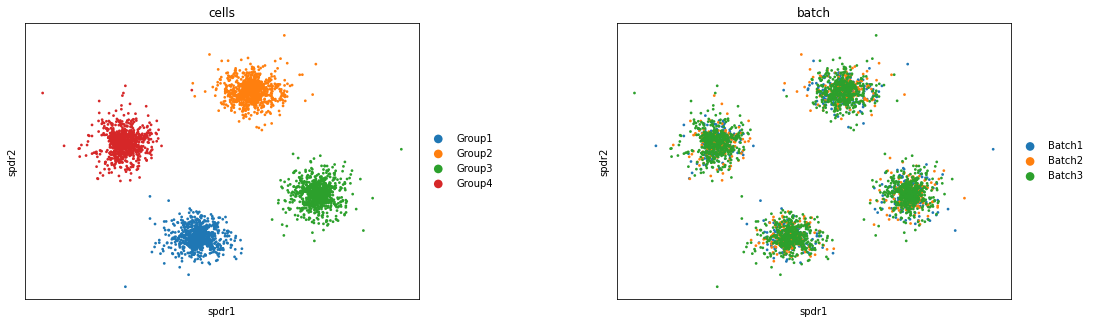

CPU times: user 17min 9s, sys: 4.46 s, total: 17min 13s
Wall time: 41.3 s


In [6]:
%%time
adata.obs[BatchID]=adata.obs[BatchID].astype(str)
triplets, weights = generate_triplets(adata,
                      batch_key=BatchID,
                      dr="pca",
                      k_mnn=10,
                      k_mnn2=0,
                      k_nn=10,
                      k_out=10,
                      k_rand=5,
                      weight_adj=500.0,
                      approx=True,
                      verbose=True)
maprules = {v: i for i, v in enumerate(adata.obs_names)}
zz = np.array(list(map(lambda x: [maprules[i] for i in x], triplets)), dtype=np.int32)
Y = spdr(X=adata.obsm["X_pca"][:, :50].astype(np.float32),
         triplets=zz,
         n_iters=1000,
         weights=weights.astype(np.float32),
         Yinit=adata.obsm["X_tsne"][:, :2]*0.001,return_seq=True)# tsne are better than umap

adata.obsm['X_spdr'] = Y[list(Y)[-1]]
sc.pl.scatter(adata, basis="spdr", color=["cells", "batch"])

Save results.

In [7]:
"""save iteration results during training"""
z=[np.hstack([v,np.ones(shape=(v.shape[0],1))*int(k)]) for k,v in Y.items()]
df0=pd.DataFrame(np.vstack(z),columns=["SPDR1","SPDR2","iter"])
df0['iter']=df0.iter.astype(int)
df0['celltype']=list(adata.obs.cells.astype(str).values)*len(Y)
df0['BatchID']=list(adata.obs.batch.astype(str).values)*len(Y)
df0.to_csv("../results/simulation1_spdr_seq.tsv.gz",sep="\t",index=False)#compression='gzip'

"""save final result"""
df0=pd.DataFrame(Y[list(Y)[-1]])
df0['celltype']=adata.obs.cells.astype(str).values
df0['BatchID']=adata.obs.batch.astype(str).values
df0.to_csv("../results/simulation1_spdr.tsv.gz",sep="\t",index=False)#compression='gzip'